## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
print(df.group.value_counts())
print(df.landing_page.value_counts())

treatment    147276
control      147202
Name: group, dtype: int64
new_page    147239
old_page    147239
Name: landing_page, dtype: int64


In [7]:
df.query('((group == "treatment") & (landing_page != "new_page")) | ((group != "treatment") & (landing_page == "new_page"))').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [8]:
# same result can be derived by counting the rows where control doesn't match old_page
df.query('((group == "control") & (landing_page != "old_page")) | ((group != "control") & (landing_page == "old_page"))').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# We'll first copy our df into a new df2.
df2 = df.copy()

In [11]:
# Here, we'll be removing the rows where the landing_page and group columns don't match
df2 = df2.drop(index=df2.query('((group == "treatment") & (landing_page != "new_page")) | ((group != "treatment") & (landing_page == "new_page"))').index)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer the following questions.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.count()

290585

In [14]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2 = df2.drop(df2[df2.user_id.duplicated()].index)

In [18]:
# confirm the duplicate row has been dropped
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the following questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.value_counts(normalize=True)  # 11.96%

0    0.880403
1    0.119597
Name: converted, dtype: float64

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2.query('group == "control"').converted.mean() # 12.04%

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
df2.query('group == "treatment"').converted.mean()  # 11.88%

0.11880806551510564

In [22]:
# Here, we'll calculate the observed difference between the conversion rate for the old and new pages.
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [23]:
df2.landing_page.value_counts(normalize=True)['new_page'] # 50.01%

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From the above results, it seems like the control group is doing better than the treatment group when it comes to average conversion rate. However, _We wouldn't be able to make a final decision_ using only the results given above as it could have happened by chance. To be able to give a more conclusive statement regarding whether to use the new treatment page or keep the landing page, _we'll need to employ more comprehensive statisical methods_ (e.g., bootstrapping and hypothesis testing) which we'll do in the upcoming section.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0$: $p_{new} - p_{old} \leq 0$**

**$H_1$: $p_{new} - p_{old} > 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
# Under the null, we stated that there's no difference in the conversion rates between the new page and the old page.
# Hence we'll take the average conversion rate for the new page to equal that for the whole dataset.
df2.converted.mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
# And we'll take the average conversion rate for the old page to equal that for the whole dataset as well.
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
# Create a sample of the number of individuals in the treatment group
df2_treatment = df2.query('group == "treatment"')
b_samp = df2_treatment.sample(df2_treatment.shape[0], replace=True)
new_page_converted = b_samp.converted
new_page_converted

367       0
195943    0
224379    0
25942     0
143873    0
1931      1
281090    0
147003    0
34146     0
189781    0
84657     0
254548    0
136584    0
219221    0
177023    0
86802     0
37261     1
119328    0
19211     1
137048    0
138748    1
63843     0
188557    0
162198    0
87033     0
215630    0
245432    0
266165    0
81124     0
277606    0
         ..
272171    0
70050     0
190481    1
99574     0
224287    0
204266    0
172765    0
116240    0
222759    1
258077    0
270860    1
111456    0
284299    0
102508    0
229523    0
96043     1
33295     0
154769    0
262859    0
266498    0
182770    0
1886      1
46203     0
27882     1
127181    0
112227    0
115096    0
110258    0
44817     0
173270    0
Name: converted, Length: 145310, dtype: int64

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
# Create a sample of the number of individuals in the control group
df2_control = df2.query('group == "control"')
b_samp = df2_control.sample(df2_control.shape[0], replace=True)
old_page_converted = b_samp.converted
old_page_converted

45128     0
12352     0
23233     0
88261     0
233191    0
259040    0
269102    1
38498     0
241871    0
254397    0
282494    0
156691    0
225797    0
64514     0
266610    1
212922    0
268915    0
12506     0
126035    0
200768    0
75483     0
268797    1
64795     1
213420    1
107062    0
276089    0
59739     0
473       1
151708    0
27241     1
         ..
158522    0
62277     1
33712     0
122591    0
48035     1
40238     0
97628     0
12813     0
148522    0
233700    0
53932     0
26459     1
349       0
24269     0
116224    0
19856     0
75574     0
244414    1
257972    0
126283    0
132508    0
41458     0
170213    0
33419     0
76342     0
143627    1
174130    0
111583    0
36159     0
223408    0
Name: converted, Length: 145274, dtype: int64

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted.mean() - old_page_converted.mean()

-0.0007658767421594992

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
# Create a sampling distribution of the difference in proportions with bootstrapping
p_diffs = []
for _ in range(10000):
    b_samp = df2.sample(df2.shape[0], replace=True)
    p_new_page = b_samp.query('group == "treatment"').converted.mean()
    p_old_page = b_samp.query('group == "control"').converted.mean()
    p_diffs.append(p_new_page - p_old_page)

#convert to NumPy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

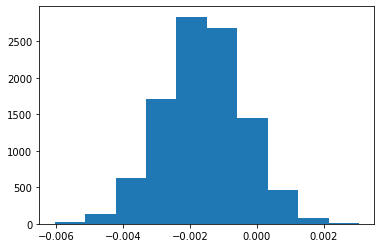

In [32]:
# Plot sampling distribution
plt.hist(p_diffs);

In [33]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

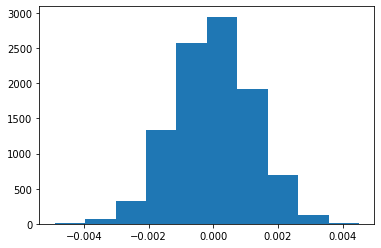

In [34]:
# Plot the null distribution
plt.hist(null_vals);

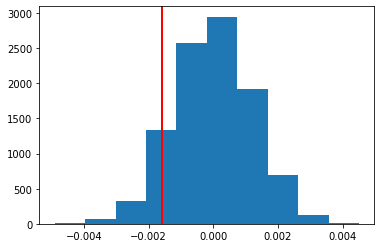

In [35]:
# Plot observed statistic with the null distibution

plt.hist(null_vals)
plt.axvline(x=obs_diff, color='r', linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
# Compute p-value

(null_vals > obs_diff).mean()

0.904

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The proportion we calculated in part j is known as the P-value. With this quite large P-Value, and with a Type I Error rate of 0.05, we fail to reject the null hypothesis and that implies we should keep our old landing page as we have statistical evidence that the new page has similar or lower average conversion rate.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query("(landing_page == 'old_page') & (converted == 1)").shape[0]
convert_new = df2.query("(landing_page == 'new_page') & (converted == 1)").shape[0]
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
ztest, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], 0, alternative='smaller')
print('{0:0.4f}'.format(pval))

0.9051


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**With the above P-value of 0.9051 that is larger than our Type I Error rate of 0.05, we fail to reject the null hypothesis which again implies that we shall keep using our old page. And that fully agrees with what we found in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression would work best for that purpose as it's a categorical variable that we're trying to predict.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
# Add an intercept column
df2['intercept'] = 1

In [40]:
# Create dummy variables for landing page column
df2[['ab_page', '_']] = pd.get_dummies(df2.landing_page)

In [41]:
# Get rid of the extra dummy variable column to make the explanatory variables dataframe full rank.
df2 = df2.drop('_', axis=1)

# Show final result
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [42]:
# Here, we'll instantiate, fit and get a summary of our model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:19:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
# coefficient for new landing page compared to the old one.
1 / np.exp(-0.015)

1.015113064615719

**The above coefficient means that when someone visits the new landing page they are 1.015 times _less likely_ to convert than if they visited the old landing page, holding all other variables constant.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The P-value associated with ab_page is 0.190. This P-value is different than the one we had in part II because our alternative hypothesis here is different in a way that makes our Logistic regression test two-sided rather than the one-sided test we had in part II**

**For the Logistic regression test:**

**$$H_0: p_{new} - p_{old} = 0$$**

**$$H_1: p_{new} - p_{old} != 0$$**


**For the hypothesis test conducted in part II:**

**$$H_0: p_{new} - p_{old} \leq 0$$**

**$$H_1: p_{new} - p_{old} > 0$$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It could be a good idea to add other factors into our model since our R-squared for this model is quite low which indicates that a low percentage of our conversions are explained by the type of the landing page. On the other side, there can be disadvantages for adding complicated terms like higher order terms as that would make our coefficients less interpretable**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
countries = pd.read_csv("countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# left join on the user_id column
merged = df2.merge(countries, how='left', on='user_id')
merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [46]:
# take a look on the new column
merged.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
# create dummy variables for the new column and populate them in the new merged dataframe
merged[['Canada', 'UK', 'US']] = pd.get_dummies(merged.country)

In [48]:
# For our model we'll use Canada as our baseline category, hence it won't be included in the explanatory variabes
# We'll first add an intercept

merged['intercept'] = 1

In [49]:
merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,Canada,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [50]:
# Here, we'll instantiate, fit and get a summary of our model
logit_mod = sm.Logit(merged['converted'], merged[['intercept', 'ab_page', 'UK', 'US']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        11:19:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [51]:
# the coefficient for UK compared to our baseline Canada
np.exp(0.0506)

1.0519020483004984

We could have interpreted the above coefficient that when someone from UK visits our website, they're 1.0519 times _more likely_ to convert compared to if they were from Canada. **However, with a P-value higher than 0.05, that outcome is not statistically significant.**

In [52]:
# the coefficient for US compared to our baseline Canada
np.exp(0.0408)

1.0416437559600236

We could have interpreted the above coefficient that when someone from US visits our website, they're 1.0416 times _more likely_ to convert compared to if they were from Canada. **However, with a P-value higher than 0.05, that outcome is not statistically significant.**


#### Hence we can conclude from the above that the country has no significant effect on conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
# adding an interaction term between the page and the country 
# we'll add two interaction terms, one between UK and ab_page
# and the other between US and ab_page

merged['UK_page'] = merged.UK * merged.ab_page
merged['US_page'] = merged.US * merged.ab_page

In [54]:
logit_mod = sm.Logit(merged['converted'], merged[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        11:20:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**For this model, we would expect the interaction terms to be helpful if the relationship between the conversion rate and the landing page depends on which country the user is in.**

In [55]:
# The coefficient for someone who vistied the new page from the UK
np.exp(0.0783)

1.0814470441230692

The above coefficient could have been interpreted that when someone from UK visits the new landing page, they're 1.08 times more likely to convert than _(our baseline)_ someone from Canada visiting the old page. **However, with the above P-value being higher than 0.05, that outcome is not statistically significant.**

In [56]:
# The coefficient for someone who vistied the new page from the US
np.exp(0.0469)

1.048017202119183

The above coefficient could have been interpreted that when someone from US visits the new landing page, they're 1.05 times more likely to convert than _(our baseline)_ someone from Canada visiting the old page. **However, with the above P-value being higher than 0.05, that outcome is not statistically significant.**

#### Hence we can conclude from the above that there is no significant effect on conversion that can be induced from the interaction terms. Moreover, the relationship between the conversion rate and the landing page _does not depend_ on the country the user is in.

### Additional Exploratory Section: Time of day effect on conversion rate

In this section we'll check the influence associated with time on conversion rates. We'll represent time here as the time of the day and we'll build a regression model to see how conversion rates differ between different times of day.



In [57]:
merged['timestamp'] = pd.to_datetime(merged['timestamp'])
merged['hour'] = merged['timestamp'].dt.hour
merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,Canada,UK,US,UK_page,US_page,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,1


In [58]:
# categorize hour column to represent the time of day.
def label_time(row):
    if 5 <= row['hour'] < 12:
        return 'Morning'
    if 12 <= row['hour'] < 17:
        return 'Afternoon'
    if 17 <= row['hour'] < 21:
        return 'Evening'
    else:
        return 'Night'

In [59]:
# apply the above function to get the new column with day time categories.
merged['DayTime'] = merged.apply(lambda x: label_time(x), axis=1)
merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,Canada,UK,US,UK_page,US_page,hour,DayTime
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,22,Night
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,8,Morning
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1,16,Afternoon
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1,18,Evening
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,1,Night


In [60]:
# get dummy variables for each time of day
pd.get_dummies(merged.DayTime)

,Afternoon,Evening,Morning,Night
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,0,1,0,0
4,0,0,0,1
5,1,0,0,0
6,0,0,0,1
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0


In [61]:
# store into columns in the dataframe
merged[['Afternoon', 'Evening', 'Morning', 'Night']] = pd.get_dummies(merged.DayTime)

In [62]:
# instantiate and fit the regression model based on time of day
# we'll use the night category as our baseline
logit_mod = sm.Logit(merged.converted, merged[['intercept', 'Afternoon', 'Evening', 'Morning']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:               2.588e-05
Time:                        11:20:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1383
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0150      0.010   -201.856      0.000      -2.035      -1.995
Afternoon      0.0246      0.016      1.541      0.123      -0.007       0.056
Evening        0.0328      0.017      1.916      0.055      -0.001       0.066
Morning        0.0277      0.015      1.909      0.056      -0.001       0.056
==============================================================================
"""

In [63]:
# interpret the coefficient for Morning
np.exp(0.0277)

1.028087211989277

The above coefficient can be interpreted that someone visisting our website in the morning is 1.028 times more likely to convert than someone visiting in the night. **With a P-value of 0.056 higher than 0.05, this doesn't have statistical significance.**

In [64]:
# interpret the coefficient for Afternoon
np.exp(0.0246)

1.024905076490493

The above coefficient can be interpreted that someone visisting our website in the afternnoon is 1.025 times more likely to convert than someone visiting in the night. **With a P-value of 0.123 higher than 0.05, this doesn't have statistical significance.**

In [65]:
# interpret the coefficient for Evening
np.exp(0.0328)

1.03334384980309

The above coefficient can be interpreted that someone visisting our website in the evening is 1.033 times more likely to convert than someone visiting in the night. **With a P-value of 0.055 higher than 0.05, this doesn't have statistical significance.**

#### Overall, we can conclude that the time of the day doesn't have statistical significance on the conversion rates.

In [66]:
merged.timestamp.min()   # date and time when we started the experiment

Timestamp('2017-01-02 13:42:05.378582')

In [67]:
merged.timestamp.max()   # date and time when we ended the experiment

Timestamp('2017-01-24 13:41:54.460509')

In [68]:
merged.timestamp.max() - merged.timestamp.min()   # duration of the experiment

Timedelta('21 days 23:59:49.081927')

#### Overall Conclusion: From the above analysis, we conclude that for now the company should stick to the old landing page as there's no statistical evidence that the new page is better. However, as we can see in the above cell that the experiment has ran for around 22 days, so our results might be influenced by change aversion. Hence, we can suggest to run the experiment long enough for existing users to acclimate to the changes.